# Hydro energy generation for Eastern and North-Eastern regions of India

### Importing libraries and setting figure size and style

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('fivethirtyeight')

### Loading the dataset for Hydro energy generation for Eastern and North-Eastern regions of India

In [3]:
df = pd.read_csv('/Users/devikarajasekar/Documents/SCHOOL/ML PROJ/datasets/eastern-hydro.csv', index_col=0, parse_dates=True)
df = df.asfreq('MS')
df.head()

,ACTUAL
Date,
2020-09-01,3334.23
2020-10-01,2991.53
2020-11-01,1686.06
2020-12-01,1263.04
2021-01-01,1237.07


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24 entries, 2020-09-01 to 2022-08-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ACTUAL  24 non-null     float64
dtypes: float64(1)
memory usage: 384.0 bytes


<AxesSubplot:xlabel='Date'>

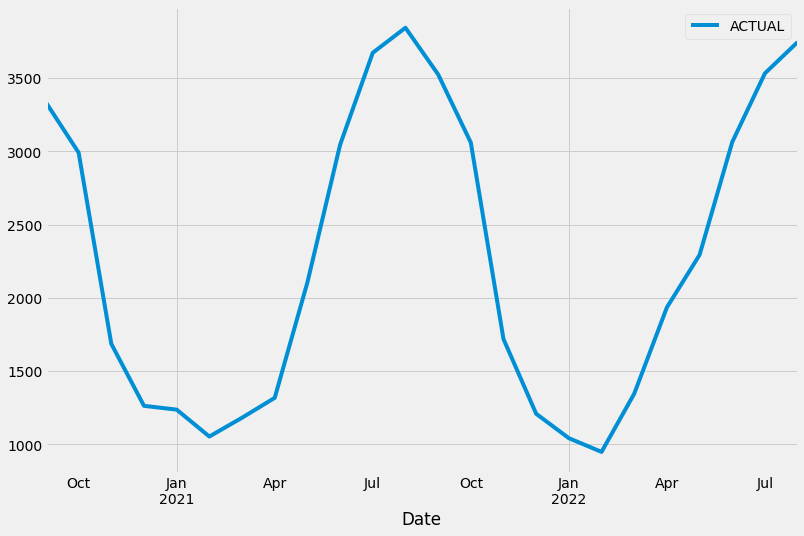

In [5]:
df.plot()

## Exploratory data analysis

### Checking for seasonality

In [6]:
X = df.values

In [7]:
from math import sin
from math import radians
 
# Function to create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff
 
# Function to invert the differenced forecast
def inverse_difference(last_ob, value):
	return value + last_ob

Clearly, seasonality can be observed in the dataset from the plot.

#### Differencing to Remove Seasonality

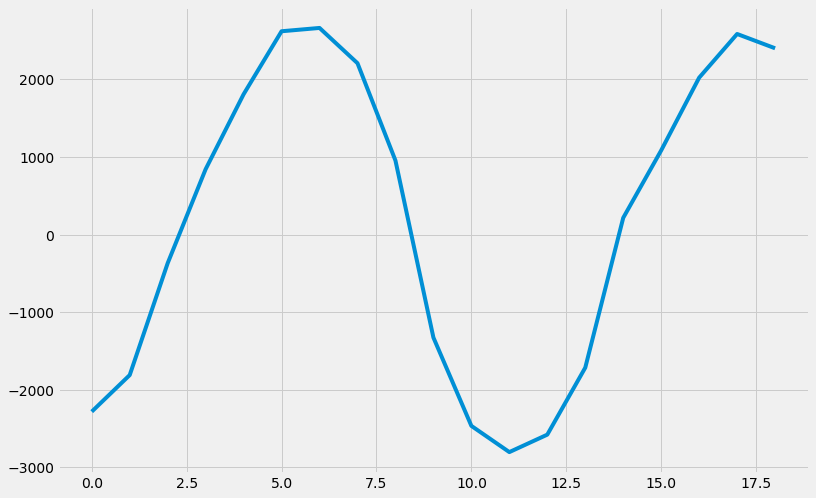

In [8]:
# Applying difference transform to the dataset and plotting
diff = difference(X, 5)
plt.plot(diff)
plt.show()

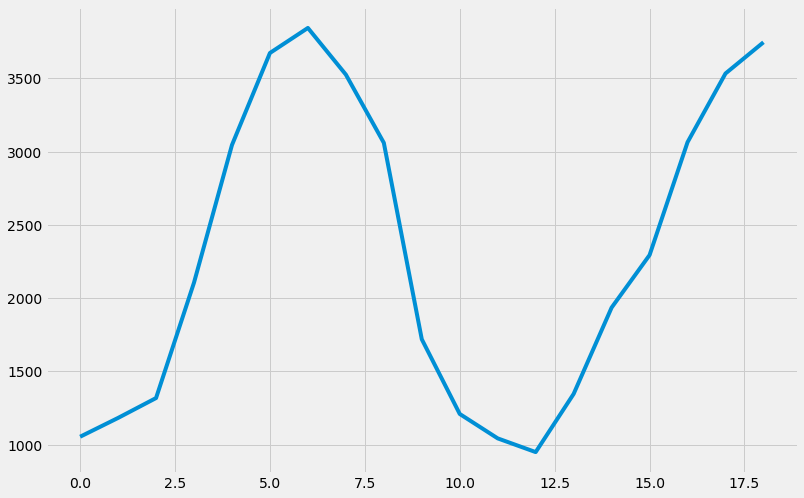

In [9]:
# Finally, the transform is inverted showing the second cycle with the seasonality restored.
inverted = [inverse_difference(X[i], diff[i]) for i in range(len(diff))]
plt.plot(inverted)
plt.show()

### Checking for Stationarity

Using **Dickey-Fuller test** since it is a more accurate method.

Sign of obvious trends, seasonality, or other systematic structures in the series are indicators of a non-stationary series.

Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.


Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have a time-dependent structure.


We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).


*p-value* > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.


*p-value* <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [10]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.551222
p-value: 0.103503
Critical Values:
	1%: -4.012
	5%: -3.104
	10%: -2.691


Hence, this data is non-stationary.

Performing log-transformation of data to convert non-stationary data to stationary data

In [11]:
X = np.log(X)
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.261800
p-value: 0.184584
	1%: -4.012
	5%: -3.104
	10%: -2.691


Data is still non-stationary.

#### Transforming non-stationary series to make it stationary

Using differencing (involves taking the differences of consecutive observations)

In [12]:
Xd = df.diff(periods=1)
Xd

,ACTUAL
Date,
2020-09-01,NaN
2020-10-01,-342.70
2020-11-01,-1305.47
2020-12-01,-423.02
2021-01-01,-25.97
2021-02-01,-183.55
2021-03-01,128.30
2021-04-01,135.76
2021-05-01,788.01


In [13]:
Xd = Xd.dropna()

In [14]:
results = adfuller(Xd)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.261800
p-value: 0.184584
Critical Values:
	1%: -4.012
	5%: -3.104
	10%: -2.691


Now, the data is stationary since p-value<0.05

### Autocorrelation analysis

Using Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots to decide whether some data is best suited to an MA model or an AR model.

Selecting the right model order is of great importance to predictions.

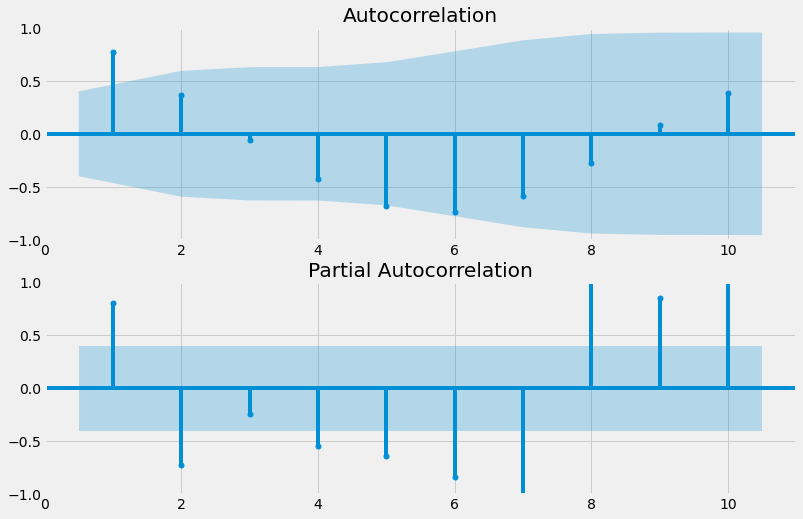

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))

# Plot the ACF of df
plot_acf(df, lags=10, zero=False, ax=ax1);

# Plot the PACF of df
plot_pacf(df, lags=10, zero=False, ax=ax2);

#### Interpretation of the plots

Blue area depicts the 95% confidence interval and is an indicator of the significance threshold. That means, anything within the blue area is statistically close to zero and anything outside the blue area is statistically non-zero.

There are several autocorrelations that are significantly non-zero. Therefore, the time series is non-random.

**Strong correlation at a lag of 7 in PACF plot**
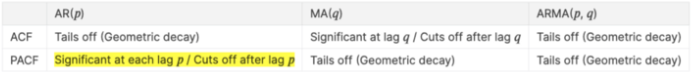

Hence, we try AR(p=7) model

## Implementing AutoRegression models

### Implementing Auto Regressive model with p = 7

In [16]:
from statsmodels.tsa.ar_model import AutoReg
ar_model = AutoReg(df['ACTUAL'], lags = 7).fit()
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                 ACTUAL   No. Observations:                   24
Model:                     AutoReg(7)   Log Likelihood                -114.041
Method:               Conditional MLE   S.D. of innovations            198.216
Date:                Wed, 02 Nov 2022   AIC                            246.082
Time:                        12:31:15   BIC                            253.581
Sample:                    04-01-2021   HQIC                           246.827
                         - 08-01-2022                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2802.0919    637.975      4.392      0.000    1551.684    4052.499
ACTUAL.L1      0.7361      0.223      3.307      0.001       0.300       1.172
ACTUAL.L2     -0.1464      0.282     -0.519      0.603      -0.699       0.406
ACTUAL.L3     -0.2316      0.280     -0.826      0.409      -0.781       0.318
ACTUAL.L4     -0.3199      0.282     -1.133      0.257      -0.873       0.233
ACTUAL.L5      0.2087      0.266      0.784      0.433      -0.313       0.731
ACTUAL.L6     -0.2002      0.225     -0.891      0.373      -0.641       0.240
ACTUAL.L7     -0.2878      0.189     -1.524      0.127      -0.658       0.082
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.8647           -0.5063j            1.0020           -0.0843
AR.2            0.8647           +0.5063j            1.0020            0.0843
AR.3            0.4797           -1.0567j            1.1605           -0.1822
AR.4            0.4797           +1.0567j            1.1605            0.1822
AR.5           -0.8368           -0.8954j            1.2255           -0.3696
AR.6           -0.8368           +0.8954j            1.2255            0.3696
AR.7           -1.7109           -0.0000j            1.7109           -0.5000
-----------------------------------------------------------------------------
"""

In [17]:
# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(ar_model.resid))
# Print mean absolute error
print(mae)

133.4109679557492


### Autocorrelation analysis with Stationary data

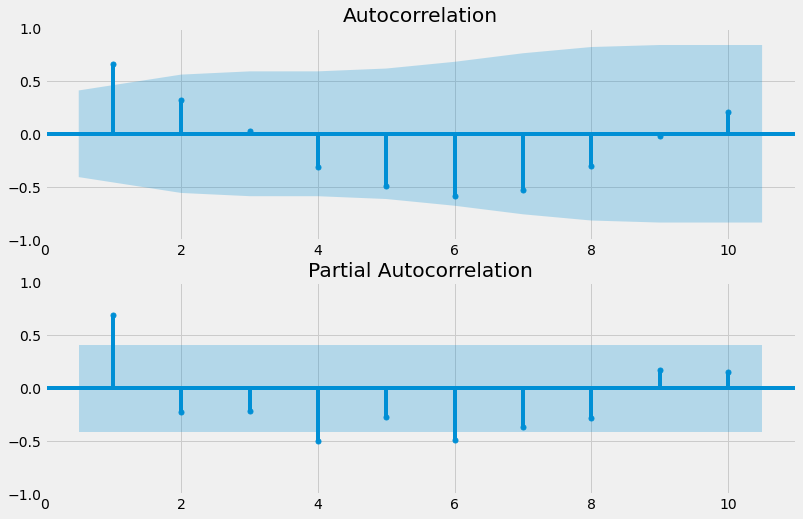

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))

# Plot the ACF of df
plot_acf(Xd.dropna(), lags=10, zero=False, ax=ax1);

# Plot the PACF of df
plot_pacf(Xd.dropna(), lags=10, zero=False, ax=ax2);

#### Interpretation of the plots

Blue area depicts the 95% confidence interval and is an indicator of the significance threshold. That means, anything within the blue area is statistically close to zero and anything outside the blue area is statistically non-zero.

There are several autocorrelations that are significantly non-zero. Therefore, the time series is non-random.

High degree of autocorrelation between adjacent (lag = 1) in PACF plot
Geometric decay in ACF plot

Based on the above table, we can use an AR(1) model to model this process.
With AR(p=1), the formula


can be rewritten to the following:



In [19]:
from statsmodels.tsa.ar_model import AutoReg
ar_model = AutoReg(Xd[['ACTUAL']], lags = 1).fit()
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                 ACTUAL   No. Observations:                   23
Model:                     AutoReg(1)   Log Likelihood                -165.287
Method:               Conditional MLE   S.D. of innovations            443.247
Date:                Wed, 02 Nov 2022   AIC                            336.575
Time:                        12:31:16   BIC                            339.848
Sample:                    11-01-2020   HQIC                           337.346
                         - 08-01-2022                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.3225     94.511      0.300      0.764    -156.916     213.561
ACTUAL.L1      0.6615      0.158      4.183      0.000       0.351       0.971
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5118           +0.0000j            1.5118            0.0000
-----------------------------------------------------------------------------
"""

AR(1) model fits an alpha_1 = 0.6615, which is  close to the alpha_1 = 0.5 that we have set.

In [20]:
# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(ar_model.resid))
# Print mean absolute error
print(mae)

333.26542624648414


Since the error is high, other models are explored.

## SARIMA models

## SARIMAX model

SARIMAX(Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors) is an updated version of the ARIMA model. we can say SARIMAX is a seasonal equivalent model like SARIMA and Auto ARIMA. it can also deal with external effects. This feature of the model differs from other models.

#### Seasonal Decomposition

Time series can be composed of trend, seasonal and residual components.

Seasonal data
- Has predictable and repeated patterns
- Repeats after any amount of time

Seasonal decomposition
- time series = trend + seasonal + residual

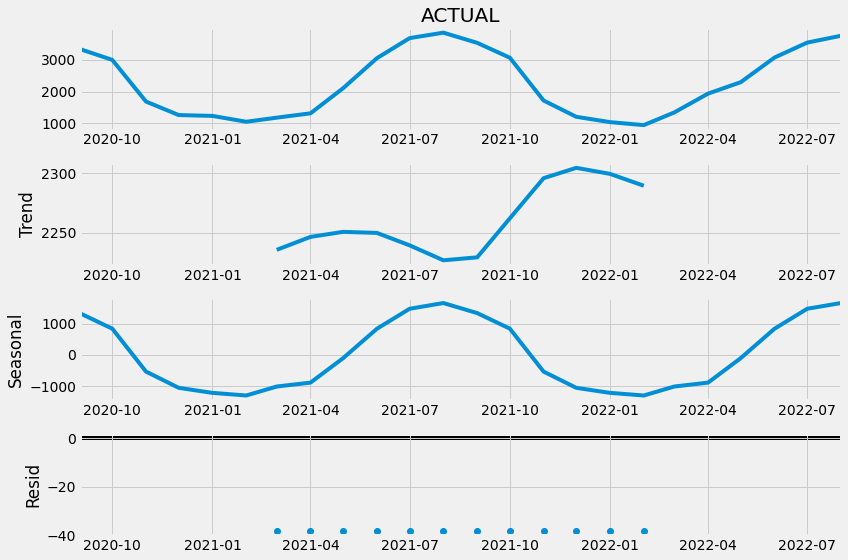

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform additive decomposition
decomp = seasonal_decompose(df['ACTUAL'], period=12)

# Plot decomposition
decomp.plot();
plt.tight_layout();

Seasonal ARIMA = SARIMA

SARIMA(p,d,q)(P,D,Q)_s 

**Non-seasonal orders**

p: autoregressive order

d: differencing order

q: moving average order


**Seasonal orders**

P: seasonal autoregressive order

D: seasonal differencing order

Q: seasonal moving average order

S: Number of time steps per cycle

#### Differencing and fitting ARMA

In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [23]:
data_diff = df.diff().dropna()

# Creating a simple ARMA(0, 2, 2) model 
arma = SARIMAX(data_diff, order=(0, 2, 2))

# Fit model
arma_results = arma.fit(disp=0)

# Print fit summary
print(arma_results.summary())

                               SARIMAX Results                                
Dep. Variable:                 ACTUAL   No. Observations:                   23
Model:               SARIMAX(0, 2, 2)   Log Likelihood                -161.285
Date:                Wed, 02 Nov 2022   AIC                            328.569
Time:                        12:31:17   BIC                            331.703
Sample:                    10-01-2020   HQIC                           329.249
                         - 08-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0503      0.305     -3.447      0.001      -1.647      -0.453
ma.L2          0.0504      0.233      0.217      0.828      -0.406       0.506
sigma2      2.461e+05   1.25e-06   1.98e+11      0.0

Unrolling ARMA forecast

In [24]:
arma_diff_forecast = arma_results.get_forecast(steps=5).predicted_mean

# Integrate the difference forecast
arma_int_forecast = np.cumsum(arma_diff_forecast)

# Make absolute value forecast
arma_value_forecast = arma_int_forecast + df.iloc[-1, 0]

# Print forecast
print("PREDICTIONS FOR NEXT 5 MONTHS: ")
print(arma_value_forecast)

PREDICTIONS FOR NEXT 5 MONTHS: 
2022-09-01    3998.525641
2022-10-01    4275.154954
2022-11-01    4576.117938
2022-12-01    4901.414593
2023-01-01    5251.044919
Freq: MS, Name: predicted_mean, dtype: float64


In [25]:
# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(arma_results.resid))

# Print mean absolute error
print(mae)

450.0857363019172


#### Fitting an ARIMA model using statsmodels instead of modeling the difference and then integrating

In [26]:
arima = SARIMAX(df, order=(0,2,0))

# Fit ARIMA model
arima_results = arima.fit(disp=0)

# Make ARIMA forecast of next 5 values
arima_value_forecast = arima_results.get_forecast(steps=5).predicted_mean

# Print forecast
print("PREDICTIONS FOR NEXT 5 MONTHS: ")
print(arima_value_forecast)

PREDICTIONS FOR NEXT 5 MONTHS: 
2022-09-01    3959.27
2022-10-01    4172.31
2022-11-01    4385.35
2022-12-01    4598.39
2023-01-01    4811.43
Freq: MS, Name: predicted_mean, dtype: float64


In [27]:
# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(arima_results.resid))

# Print mean absolute error
print("MAE: ",mae)

MAE:  602.2346494376358


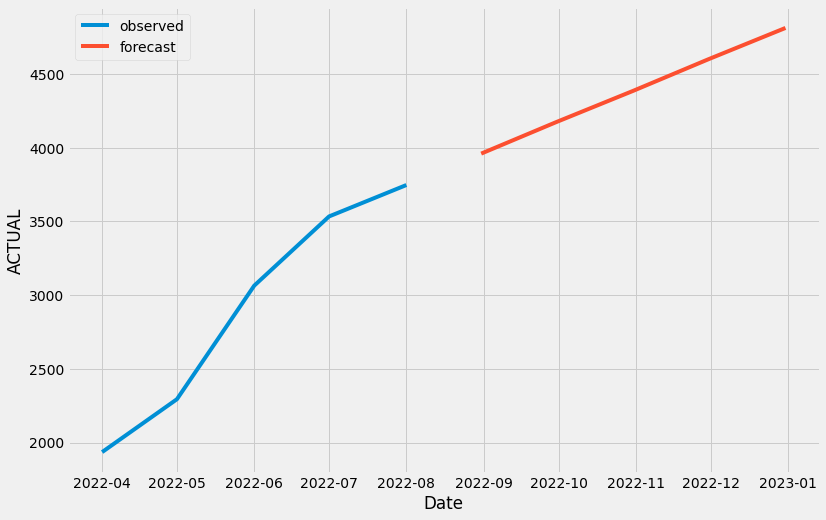

In [28]:
plt.plot(df.index[-5:], df.iloc[-5:]['ACTUAL'], label='observed');

# Plot your mean forecast
rng = pd.date_range(start='2022-08-01', end='2023-01-01',freq='M')
plt.plot(rng, arima_value_forecast.values, label='forecast');

# set labels, legends
plt.xlabel('Date');
plt.ylabel('ACTUAL');
plt.legend();


## Evaluating ARIMA model parameters

In [29]:
X = df['ACTUAL']
X.head()

Date
2020-09-01    3334.23
2020-10-01    2991.53
2020-11-01    1686.06
2020-12-01    1263.04
2021-01-01    1237.07
Freq: MS, Name: ACTUAL, dtype: float64

In [30]:
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

In [31]:
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA model: %s MSE=%.3f' % (best_cfg, best_score))

In [32]:
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)

evaluate_models(df.values, p_values, d_values, q_values)

Best ARIMA model: None MSE=inf


## Automated SARIMA model selection

### Using pmdarima package

Automatically discover the optimal order for an ARIMA model.

The auto-ARIMA process seeks to identify the most optimal
parameters for an ARIMA model, settling on a single fitted ARIMA model. 

In [33]:
# !pip install pmdarima

In [34]:
import pmdarima as pm

# Create auto_arima model
model1 = pm.auto_arima(df,
                      seasonal=True, 
                      m=12,  # period for seasonal differencing
                      D=1,  #order of seasonal differencing
                      trace=True,   #print status on the fits
                      error_action='ignore',
                      suppress_warnings=True)

# Print model summary
print(model1.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=170.297, Time=0.72 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=166.353, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=167.168, Time=0.27 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=165.221, Time=0.03 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=165.545, Time=0.08 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=164.667, Time=0.09 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=165.952, Time=0.32 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=166.396, Time=0.16 sec
 ARIMA(0,0,2)(0,1,0)[12] intercept   : AIC=165.534, Time=0.14 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=167.378, T

Using AIC (Akaike Information Criterion), best SARIMA model is chosen

Lower AIC indicates a better model

AIC likes to choose simple models with lower order

## SARIMA vs ARIMA forecasts

In [35]:
model = SARIMAX(df, order=(0,0,1), enforce_stationarity=True, enforce_invertibility=True)

arima_results = model.fit(disp=0)
print(arima_results.summary())
# ARIMA(0,0,1)(0,1,0)[12]


                               SARIMAX Results                                
Dep. Variable:                 ACTUAL   No. Observations:                   24
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -208.024
Date:                Wed, 02 Nov 2022   AIC                            420.048
Time:                        12:31:25   BIC                            422.404
Sample:                    09-01-2020   HQIC                           420.673
                         - 08-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.9995      0.444      2.253      0.024       0.130       1.869
sigma2      1.734e+06   2.57e-07   6.76e+12      0.000    1.73e+06    1.73e+06
Ljung-Box (L1) (Q):                   7.13   Jarque-

In [36]:
arima_pred = arima_results.get_forecast(24)
arima_mean = arima_pred.predicted_mean

In [37]:
#calcuate the mean squared error of the model
rmse = math.sqrt(mean_squared_error(df.values, arima_mean))
#Calculate the mean absolute error of the model 
mae = mean_absolute_error(df.values, arima_mean)

print("RMSE: ",rmse)
print("MAE: ",mae)

RMSE:  2393.613963151756
MAE:  2167.7640913758837


In [38]:
model = SARIMAX(df, order=(0,0,1), seasonal_order=(0,1,0,12), 
                enforce_stationarity=True, enforce_invertibility=True)

sarima_results = model.fit(disp=0)

In [39]:
# Getting Out-of-sample SARIMA mean forecasts
sarima_pred = sarima_results.get_forecast(24)
sarima_mean = sarima_pred.predicted_mean

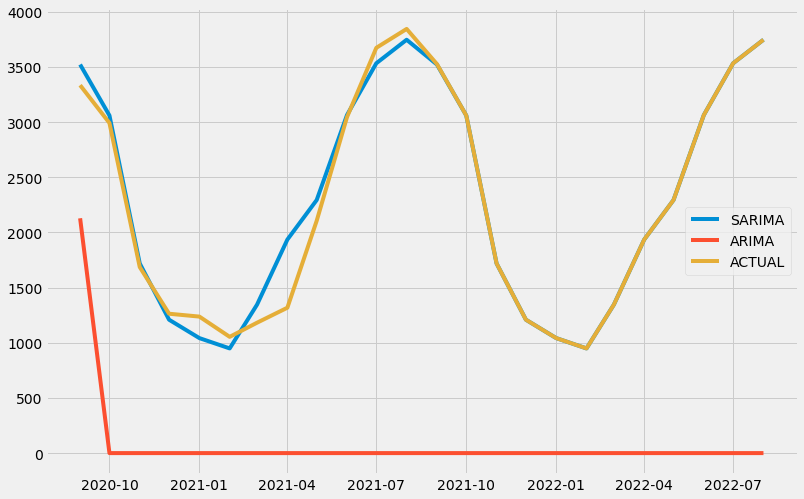

In [40]:
dates = df.index
# Plot mean ARIMA and SARIMA predictions and observed
plt.plot(dates, sarima_mean, label='SARIMA');
plt.plot(dates, arima_mean, label='ARIMA');
plt.plot(df, label='ACTUAL');
plt.legend();

### Evaluating the models

#### Plot diagnostics

**Test vs Good fit**

Standardized residual: There are no obvious patterns in the residuals

Histogram plus kde estimate:	The KDE curve should be very similar to the normal distribution

Normal Q-Q:	Most of the data points should lie on the straight line

Correlogram:	95% of correlations for lag greater than one should not be significant

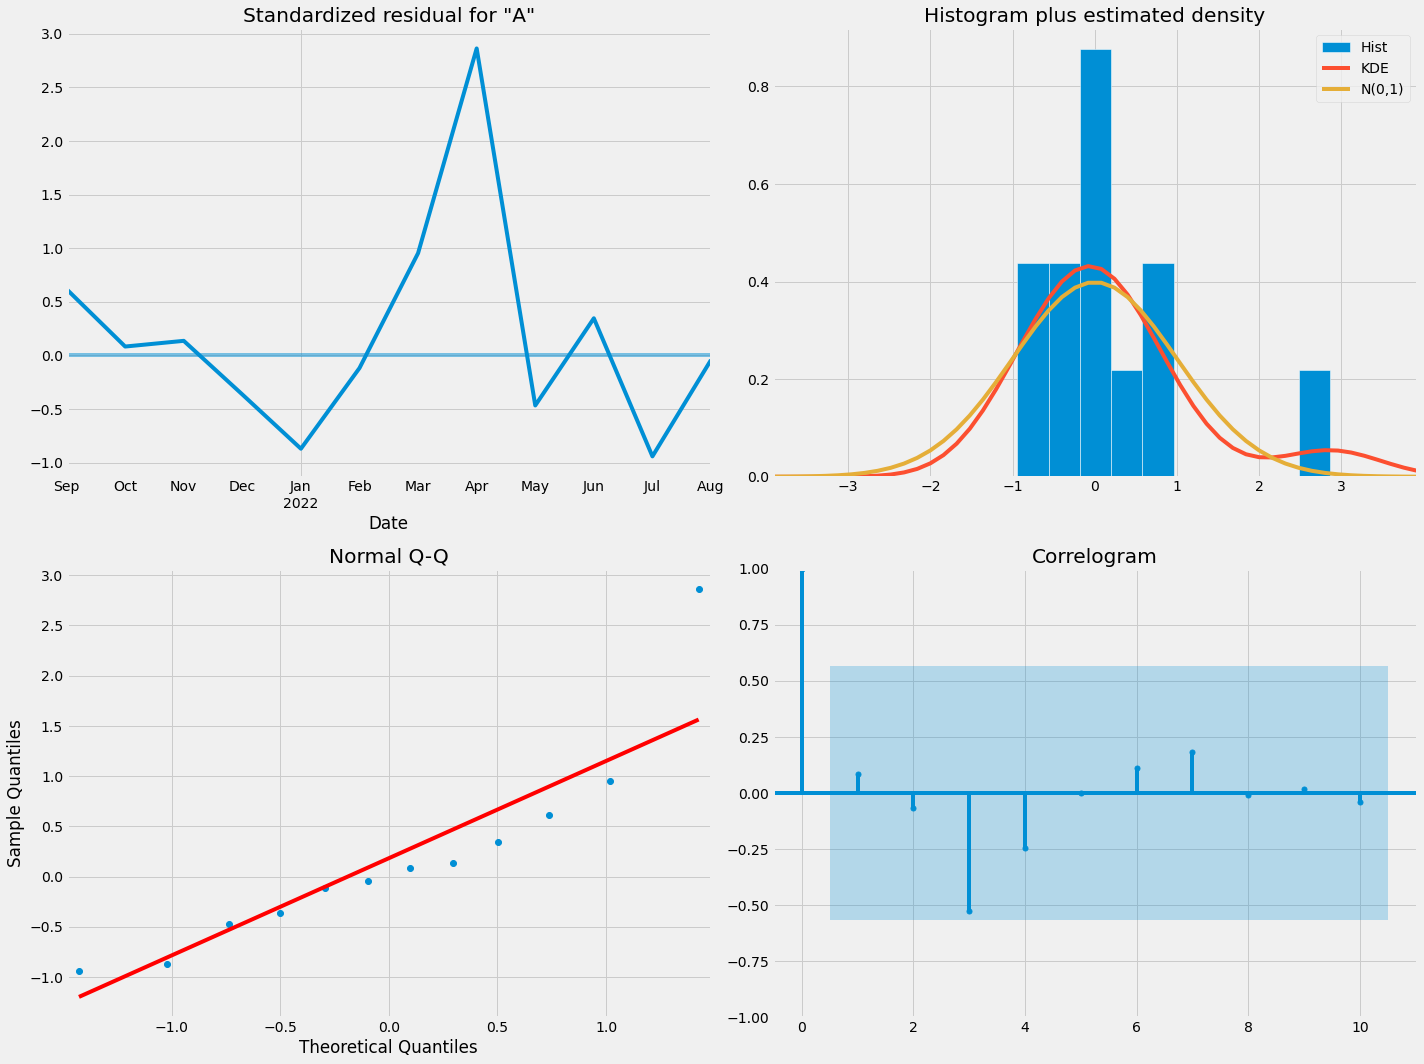

In [41]:
sarima_results.plot_diagnostics(figsize=(20, 15));
plt.tight_layout();

#### Statistical diagnostics

In [42]:
#calcuate the mean squared error of the model
rmse = math.sqrt(mean_squared_error(df.values, sarima_mean))
#Calculate the mean absolute error of the model 
mae = mean_absolute_error(df.values, sarima_mean)

print("RMSE: ",rmse)
print("MAE: ",mae)

RMSE:  153.549415703682
MAE:  78.03291666666668


### Future forecast

#### One-step prediction

In [43]:
one_step_forecast = sarima_results.get_prediction(start=-10)

# Extract prediction mean
mean_forecast = one_step_forecast.predicted_mean

# Get confidence intervals of predictions
confidence_intervals = one_step_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower ACTUAL']
upper_limits = confidence_intervals.loc[:,'upper ACTUAL']

# Print best estimate  predictions
print(mean_forecast.values)

[1693.75518466 1275.93936261 1202.26568539  970.26766067 1170.54769914
 1408.83948223 2379.5417779  3000.30943369 3706.27709262 3753.95686355]


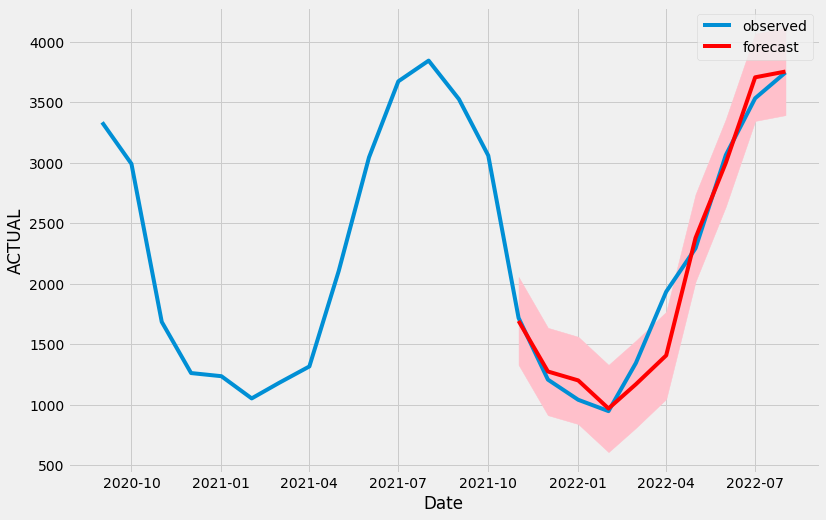

In [44]:
plt.plot(df.index, df['ACTUAL'], label='observed');

# Plot your mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast');

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink');

# Set labels, legends
plt.xlabel('Date');
plt.ylabel('ACTUAL');
plt.legend();

#### Generating dynamic predictions

In [45]:
dynamic_forecast = sarima_results.get_prediction(start=-10, dynamic=True)

# Extract prediction mean
dmean_forecast = dynamic_forecast.predicted_mean

# Get confidence intervals of predictions
confidence_intervals = dynamic_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:, 'lower ACTUAL']
upper_limits = confidence_intervals.loc[:, 'upper ACTUAL']

# Print predictions
print(dmean_forecast.values)

[1693.75518466 1263.04       1237.07       1053.52       1181.82
 1317.58       2105.59       3044.99       3673.16       3844.07      ]


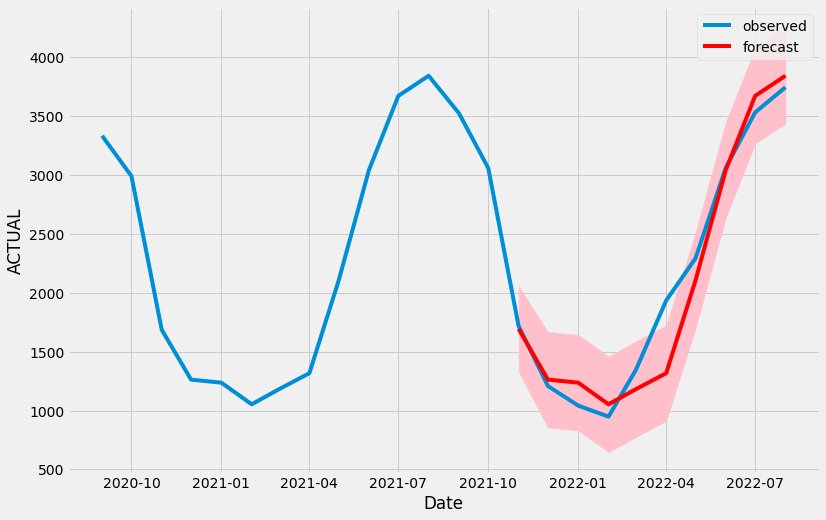

In [46]:
plt.plot(df.index, df['ACTUAL'], label='observed');

# Plot your mean predictions
plt.plot(dmean_forecast.index, dmean_forecast, color='r', label='forecast');

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink');

# Set labels, legends
plt.xlabel('Date');
plt.ylabel('ACTUAL');
plt.legend();

Making dynamic predictions, means that the model makes predictions with no corrections, unlike the one-step-ahead predictions. It is like making a forecast now for the next 5 months, and then waiting to see what happens before comparing how good the predictions were.

## Future forecasting

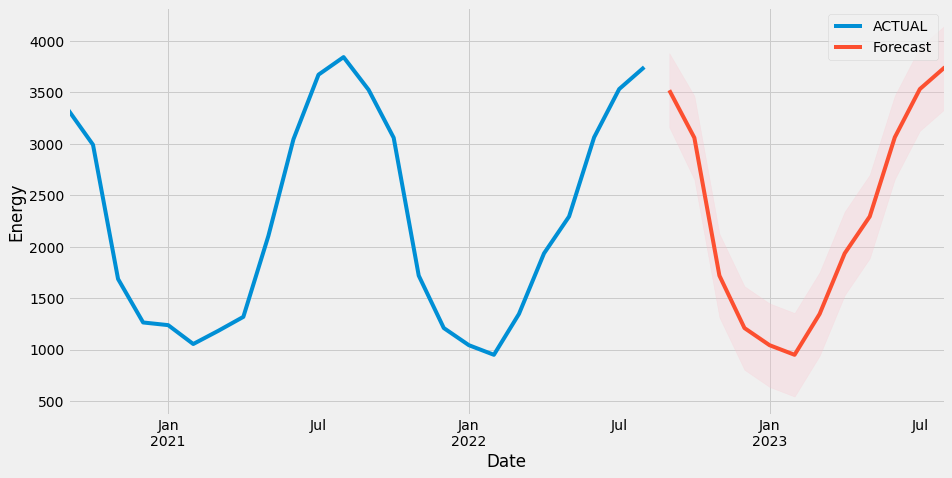

In [47]:
# Forecast 1y
pred_uc = sarima_results.get_forecast(steps=12)
pred_ci = pred_uc.conf_int()
ax = df.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='pink', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Energy')
plt.legend()
plt.show()

### Predicted energy values for the next year

In [48]:
pred_uc.predicted_mean

2022-09-01    3521.567215
2022-10-01    3059.760000
2022-11-01    1718.890000
2022-12-01    1208.830000
2023-01-01    1042.190000
2023-02-01     948.610000
2023-03-01    1345.850000
2023-04-01    1935.050000
2023-05-01    2293.720000
2023-06-01    3063.920000
2023-07-01    3533.190000
2023-08-01    3746.230000
Freq: MS, Name: predicted_mean, dtype: float64